In [70]:
import torch, transformers, datasets, diffusers, accelerate, peft
torch.__version__, transformers.__version__, datasets.__version__, diffusers.__version__, peft.__version__

('2.5.1', '4.47.1', '3.2.0', '0.33.0.dev0', '0.14.1.dev0')

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
import transformers, datasets, diffusers
from transformers import CLIPTextModel, CLIPTokenizer, CLIPProcessor, CLIPModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils import convert_state_dict_to_diffusers
from diffusers.training_utils import cast_training_params

from peft import LoraConfig
from peft.utils import get_peft_model_state_dict

# tqdm.auto에서 tqdm 로딩하면 중간에 데이터로더가 멈춤, 기다리면 다시 시작되긴 함
# 데이터 로더와 tqdm 충돌 문제
# https://discuss.pytorch.org/t/exception-ignored-in-function-multiprocessingdataloaderiter-del-at/133498
# https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/14
# from tqdm.auto import tqdm
from tqdm import tqdm

from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 로컬 데이터 Datset 생성

In [73]:
# 데이터 변환 함수
def set_label(example):
    example['text'] = 'Good' if 'Good' in example['image'].filename else 'Winding'
    return example

# 기존 데이터셋 로드
dataset = datasets.load_dataset("imagefolder", data_dir="D:/Data") # 해당 코드를 사용하면 label 0과 1로 생성 -> Text to Image 모델이기 때문에 str로 생성 필요

# 'label'을 'text'로 변환
dataset = dataset.map(set_label)

# 'label' 컬럼을 삭제하고 'text'만 남기기
dataset = dataset.remove_columns('label')

### 데이터 확인

(2560, 2560)
Good


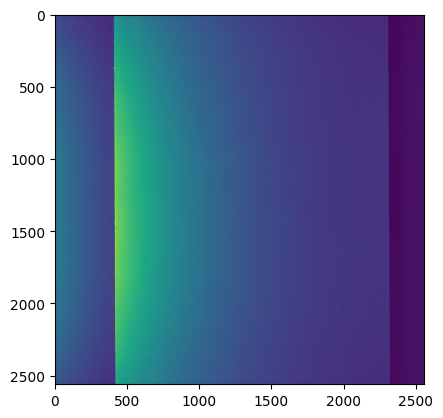

In [5]:
idx = 140
print(dataset['train'][idx]['image'].size)
print(dataset['train'][idx]['text'])
plt.imshow(np.array(dataset['train'][idx]['image']))
plt.show()

## 필요 모델 로딩

- 노이즈 스케쥴러, 텍스트 토크나이저, 텍스트 인코더, 이미지 오토인코더, unet 모델을 선학습된 상태로 각각 로딩

In [7]:
PRE_TRAINED_MODEL_NAME="model/stable-diffusion-v1-5"

noise_scheduler = DDPMScheduler.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="scheduler"
)

tokenizer = CLIPTokenizer.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="tokenizer"
)

# 학습 파라미터 있으나 고정될 것임
text_encoder = CLIPTextModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="text_encoder"
)

# 학습 파라미터 있으나 고정될 것임
vae = AutoencoderKL.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="vae"
)

# 학습 파라미터 있고 파인튜닝 될 것임
unet = UNet2DConditionModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="unet"
)

## 데이터 전처리

### 텍스트 전처리

- 샘플에 로딩된 토크나이저를 적용해 문장을 모두 정수 토큰 아이디로 바꿈

In [8]:
# 모델에 입력되는 최대 토큰 길이
tokenizer.model_max_length

77

In [9]:
# 토크나이징 테스트
tokenizer(dataset['train'][idx]['text'],
          max_length=tokenizer.model_max_length,
          padding='max_length',
          truncation=True,
          return_tensors='pt')

{'input_ids': tensor([[49406,   886, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [10]:
# 데이터 셋의 한 샘플에 대해서 text컬럼을 토크나이징 해서 되돌리는 함수
def tokenize_captions(examples, caption_column='text', is_train=True):
    captions = []

    for caption in examples[caption_column]:
        # 캡션이 하나인 경우
        if isinstance(caption, str):
            captions.append(caption)
        # 캡션이 하나 이상인 경우 아무거나 하나 선택
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )

    return inputs.input_ids

### 이미지 전처리

- 특별한것 없고 그냥 pytorch에서 제공하는 이미지 증강 기능을 사용

In [11]:
IMG_SIZE = 128
CENTER_CROP = True
RANDOM_FLIP = True

In [12]:
# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

### 종합 처리 함수

- 모든 샘플에 대해서 텍스트, 이미지 전처리 함수를 적용할 함수

In [13]:
def preprocess_train(examples, image_column='image'):
    images = [image.convert("RGB") for image in examples[image_column]]

    # 이미지 전처리
    examples["pixel_values"] = [train_transforms(image) for image in images]

    # 텍스트 전처리
    examples["input_ids"] = tokenize_captions(examples)

    return examples

## 데이터 로더

In [14]:
def collate_fn(examples):
    # (C, H, W), ..., (C, H, W) -> stack -> (N, C, H, W): N으로 스택
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # tensor.contiguous()와 동일
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # {(77,), ..., (77,)}_N개 -> stack -> (N, 77)
    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [15]:
# 데이터 실시간 변환 적용
train_dataset = dataset["train"].with_transform(preprocess_train)

In [16]:
# 데이터 컬럼을 확인하면 이시점까지는
# 'image', 'text'만 있고 pixel_values, input_ids 없음
train_dataset.column_names

['image', 'text']

In [17]:
# 실시간으로 적용되기 때문에 데이터셋 컬럼에는 변환 결과 컬럼이 없고
# 데이터를 가져와야 보임
train_dataset[0].keys()

dict_keys(['image', 'text', 'pixel_values', 'input_ids'])

In [18]:
BATCH_SIZE = 4
NUM_WORKERS = 0

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [19]:
# 데이터로더 테스트
train_dataloader_iter = iter(train_dataloader)
mini_batch = next(train_dataloader_iter)

# 이미지 데이터,                  캡션 데이터
mini_batch['pixel_values'].shape, mini_batch['input_ids'].shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 77]))

In [20]:
# 데이터로더의 이터레이션 수
len(train_dataloader)

281

In [21]:
# 참고 text_encoder의 출력
# BaseModelOutputWithPooling 이 되돌려지는데 [0]이 last_hidden_state
# 트랜스포머 인코더의 마지막 히든층 츨력이므로 크기는 (batch size, time step, model dim)
text_encoder(mini_batch['input_ids'])[0].shape

torch.Size([4, 77, 768])

## 모델 준비

In [22]:
# FP16을 AMP으로 적용하기 위한 세팅

# weight_dtype = torch.float32
weight_dtype = torch.float16 # half precision

In [23]:
# unet, vae와 텍스트 인코더는 미세조정에서 학습되지 않음
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False);

#### LoRA 어댑터 준비

In [24]:
LORA_RANK = 4

# Freeze the unet parameters before adding adapters
for param in unet.parameters():
    param.requires_grad_(False)

unet_lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

In [25]:
text_encoder.to(device);
vae.to(device);
unet.to(device);

In [26]:
# Add adapter and make sure the trainable params are in float32.
unet.add_adapter(unet_lora_config)

# 원 스크립트 소스는 모델 가중치를 모두 FP16으로 캐스팅하는데
# 여기서는 FP16으로 캐스팅하지 않고 AMP 사용하기 때문에
# 여기서는 이 부분이 필요 없을 것으로 생각되나
# 그냥 두었음
if weight_dtype == torch.float16:
    # only upcast trainable parameters (LoRA) into fp32
    cast_training_params(unet, dtype=torch.float32)

lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

## 옵티마이저 & 학습률 스케쥴러

In [27]:
EPOCHS = 30
LEARNING_RATE = 1e-04

optimizer = torch.optim.AdamW(
        lora_layers,
        lr=LEARNING_RATE,
        # betas=(args.adam_beta1, args.adam_beta2),
        # weight_decay=args.adam_weight_decay,
        # eps=args.adam_epsilon,
    )

In [28]:
lr_scheduler = get_scheduler(
        'linear',
        optimizer=optimizer,
        num_warmup_steps=500,
        num_training_steps=EPOCHS * len(train_dataloader)
    )

## 학습 루프

In [29]:
# 학습 요소들의 세팅값 확인

# 모델이 추정하는 타겟은 epsilon,       이미지 디코더 스케일 상수
noise_scheduler.config.prediction_type, vae.config.scaling_factor

('epsilon', 0.18215)

In [ ]:
# APM
# - True: 1m30s(RTX3090)/epoch, 5m00s(T4)/epoch,
# - False: 테스트 안해봄

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
prediction_type = None # 'epsilon'  or 'v_prediction'

train_losses = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(tqdm(train_dataloader)):
        # T4에서 amp autocast가 호환이 안됨
        with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp):
            # Convert images to latent space
            latents = vae.encode(
                batch["pixel_values"].to(device)
                # batch["pixel_values"].to(device, dtype=weight_dtype)
            ).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)

            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning, [0]: last_hidden_state
            encoder_hidden_states = text_encoder(batch["input_ids"].to(device) )[0]

            # 노이즈 스케쥴러에 예측 타입이 노이즈인지 이미지인지에 따라 타겟 설정
            if prediction_type is not None:
                # set prediction_type of scheduler if defined
                noise_scheduler.register_to_config(prediction_type=prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


        with torch.no_grad():
            train_losses.append(loss.item())

        # loss.backward()
        # optimizer.step()
        # lr_scheduler.step()
        # optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()

    # print loss
    avg_loss = sum(train_losses[-100:])/100
    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')


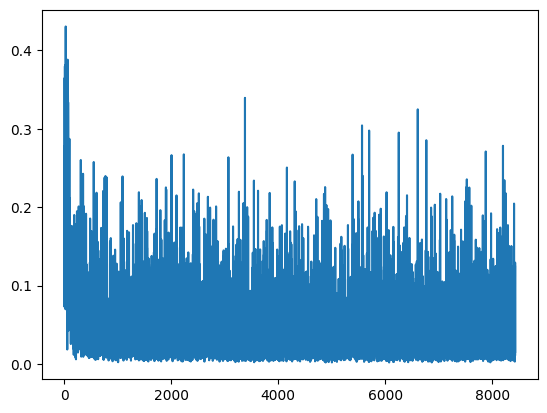

In [31]:
plt.plot(train_losses)
plt.show()

In [32]:
import pandas as pd

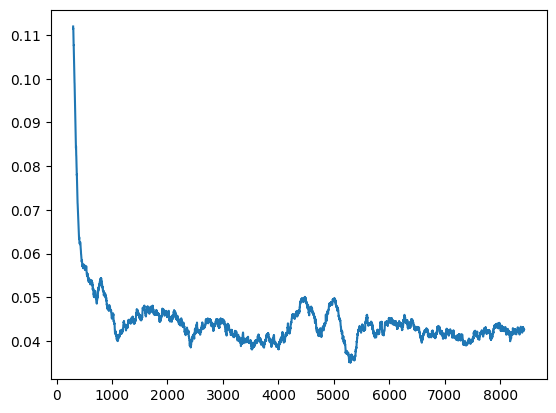

In [33]:
losses_sr = pd.Series(train_losses)
loss_mv = losses_sr.rolling(window=300).mean()

plt.plot(loss_mv)

## 이미지 생성

### 옵션 1: 직접 생성

In [34]:
prompt = ["Make more Winding pad"]

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion

num_inference_steps = 20  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance

generator = torch.manual_seed(2)  # Seed generator to create the initial latent noise

batch_size = len(prompt)

In [35]:
text_input = tokenizer(
    prompt, max_length=tokenizer.model_max_length,
    padding="max_length", truncation=True, return_tensors="pt"
)

# 시퀀스 길이 77
print(len(text_input['input_ids'][0]))

# 토큰화 결과
text_input

77


{'input_ids': tensor([[49406,  1078,   750, 22390,  7601, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [36]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input['input_ids'].to(device))[0]

# 각 토큰은 768차원 벡터로 임베딩
text_embeddings.shape

torch.Size([1, 77, 768])

In [37]:
max_length = text_input['input_ids'].shape[-1]

# 모두 공백인 ""으로 채워서 텍스트 컨디션을 없는 것으로 만듬
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

uncond_embeddings = text_encoder(uncond_input['input_ids'].to(device))[0]

In [38]:
# (1, 77, 768), (1, 77, 768) => (2, 77, 768)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 구체적인 조건이 있는것과 그냥 깡통 조건(모두 공백인)이 같이 묶임
text_embeddings.shape

torch.Size([2, 77, 768])

In [39]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
).to(device)

In [40]:
# 타임스탭 세팅
noise_scheduler.set_timesteps(num_inference_steps)
noise_scheduler.timesteps

tensor([951, 901, 851, 801, 751, 701, 651, 601, 551, 501, 451, 401, 351, 301,
        251, 201, 151, 101,  51,   1])

In [41]:
lora_scale = 0.9

for t in tqdm(noise_scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings,
            cross_attention_kwargs={"scale": lora_scale},
        ).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # CFG eq(6)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


In [42]:
# scale and decode the image latents with vae
#  0.18215는 SD개발자들이 찾아낸 디코딩이 잘되기 위한 상수
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

In [43]:
image.shape

torch.Size([1, 3, 512, 512])

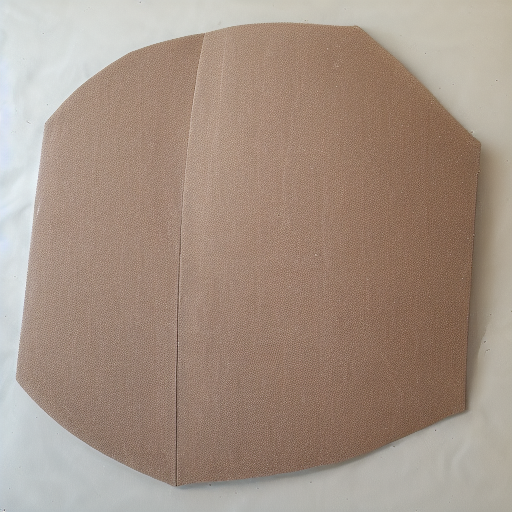

In [44]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

### 옵션2: 파이프라인 사용

In [45]:
from diffusers import StableDiffusionPipeline

In [46]:
pipeline = StableDiffusionPipeline.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet, # 미세 조정된 네트워크
)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 18.72it/s]


In [47]:
pipeline.to(device);

100%|██████████| 20/20 [00:03<00:00,  6.26it/s]


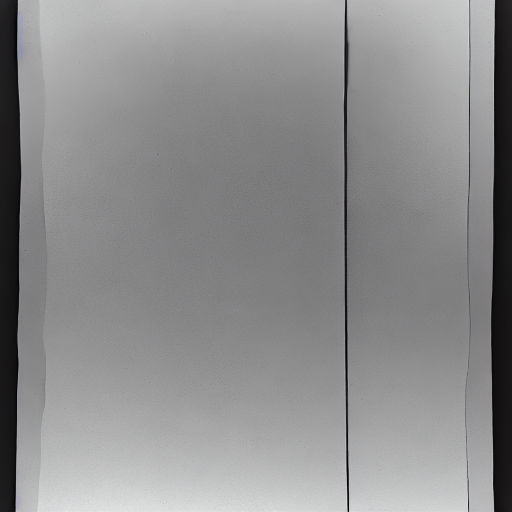

In [72]:
lora_scale = 0.9
pipeline_output = pipeline(
    #prompt=["a very cute looking cartoon character with big eyes"],
    prompt=["looking Clean Pad with Curved"],
    num_inference_steps=20,
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)
)
pipeline_output.images[0]


## 학습된 모델 파이프라인 저장

### 로컬 저장

In [50]:
pipeline.save_pretrained("./lora_finetuning_save")

In [51]:
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [52]:
list(unet_lora_state_dict.keys())[:5]

['down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora.down.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora.up.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.down.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.up.weight',
 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora.down.weight']

In [53]:
#pytorch_lora_weights.safetensors 를 저장
StableDiffusionPipeline.save_lora_weights(
    save_directory="./lora_finetuning_weights",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

### push to Hub

In [54]:
# https://huggingface.co/docs/transformers/model_sharing
# from huggingface_hub import notebook_login
# notebook_login()

In [55]:
# pipeline.push_to_hub("stable-diffusion-v1-5-finetune-pokemon-blip")

# 이미지 출력 방법 

In [61]:
# 이미 fine-tuned된 모델을 로드
pipeline = StableDiffusionPipeline.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet  # Fine-tuned UNet 모델
).to(device)

# 텍스트 프롬프트를 제공하여 학습한 이미지를 생성
prompt = ["Winding"]  # 또는 "Good"
lora_scale = 0.9

# 이미지 생성
pipeline_output = pipeline(
    prompt=prompt,
    num_inference_steps=20,  # 이미지 품질을 위한 샘플 수
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)  # 동일한 시드를 사용해 재현성 있는 결과 생성
)

# 생성된 이미지 출력
generated_image = pipeline_output.images[0]
generated_image.show()


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Generated text caption: a photo of a winding image


100%|██████████| 20/20 [00:03<00:00,  6.32it/s]


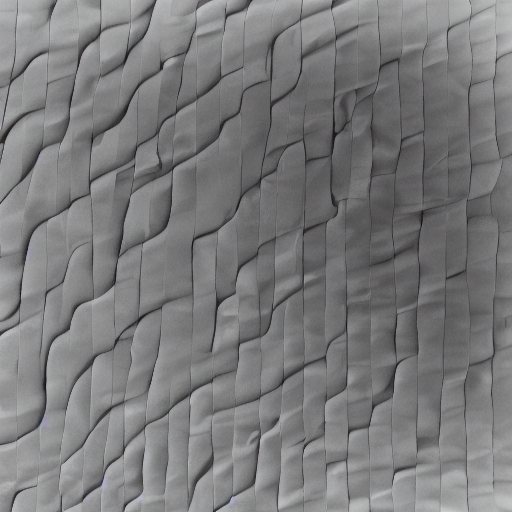

In [ ]:
# CLIP 모델 로드
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# 기존 이미지를 텍스트로 변환
def extract_text_from_image(image_path):
    image = Image.open(image_path)
    inputs = clip_processor(text=["a photo of a good image", "a photo of a winding image"], 
                            images=image, 
                            return_tensors="pt", 
                            padding=True)
    outputs = clip_model(**inputs)
    
    logits_per_image = outputs.logits_per_image # 텍스트와 이미지를 비교
    probs = logits_per_image.softmax(dim=1) # 확률로 변환
    
    caption = ["a photo of a good image", "a photo of a winding image"][torch.argmax(probs)]
    return caption

# 기존 이미지 경로
image_path = "{Image_path}"

# 이미지에서 텍스트 추출
caption = extract_text_from_image(image_path)
print(f"Generated text caption: {caption}")

# 텍스트로 비슷한 이미지 생성
pipeline_output = pipeline(
    prompt=[caption],
    num_inference_steps=20,
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)
)


# 생성된 이미지 출력
generated_image = pipeline_output.images[0]
generated_image


In [ ]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./lora_finetuning_weights",  # LoRA 가중치 저장 경로
    unet_lora_layers=unet_lora_state_dict,  # LoRA 계층 상태 사전
    safe_serialization=True,  # 안전하게 직렬화
)


In [68]:
from diffusers import StableDiffusionPipeline

# 원본 모델 로드
pipeline = StableDiffusionPipeline.from_pretrained("model/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)

# LoRA 가중치 로드
pipeline.load_lora_weights("./lora_finetuning_weights/pytorch_lora_weights.safetensors")

# 이미지 생성
image = pipeline("A beautiful landscape painting", num_inference_steps=50).images[0]

# 이미지 저장
image.save("generated_image.png")


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]
